In [65]:
from sympy import MatrixSymbol, Matrix, Identity

import sympy as sym
import math

sym.init_printing()
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import control

# IDENTIFICACIÓN DE SISTEMAS

Profesor: Jairo Alberto Cuéllar Guarnizo  
Programa: Ingeniería en Automatización y Control

In [1]:
import numpy as np
import pandas as pd

# Establecemos una semilla aleatoria para la replicabilidad
np.random.seed(123)

# Definimos el número de observaciones
nobs = 1000

# Generamos datos exógenos aleatorios
exog = np.random.randn(nobs, 2)

# Generamos datos endógenos aleatorios
endog = np.random.randn(nobs)

# Creamos un dataframe con los datos
data = pd.DataFrame(np.column_stack((endog, exog)), columns=['y', 'x1', 'x2'])
data

,y,x1,x2
0,-1.774224,-1.085631,0.997345
1,-1.201377,0.282978,-1.506295
2,1.096257,-0.578600,1.651437
3,0.861037,-2.426679,-0.428913
4,-1.520367,1.265936,-0.866740
...,...,...,...
995,-0.075335,-1.080413,0.160889
996,-0.946199,-0.602575,0.699329
997,2.040432,1.847453,0.845701
998,1.015917,-1.119923,-0.359297


## Definimos espacio de entrenamiento

In [96]:
# Definimos el tamaño de los conjuntos de entrenamiento y prueba
nobs_train = 800

# Dividimos los datos en conjuntos de entrenamiento y prueba
train_data = data[:nobs_train]
test_data = data[nobs_train:]

## Calculando los parámetros
$$\theta_{ls} = \phi^+.y[k]$$


La regresión lineal continúa siendo el modelo que se está estimando y la estimación de parámetros puede hacerse por los métodos de mínimos cuadrados discutidos con anterioridad.

In [97]:
# Parámetro para la regularización de los minimos cuadrados (entre 0 y 1)
# Garantiza que la matriz (phi^T*phi)^-1 exista y se pueda estimar 
#los parámetros.
alpha = 0
A = np.dot(phi.T,phi) + alpha*np.eye(len(np.dot(phi.T,phi)))
theta = np.dot(np.linalg.inv(A),np.dot(phi.T,yn))
theta

array([-0.33425775,  0.14305689,  0.15136539,  0.39115122])

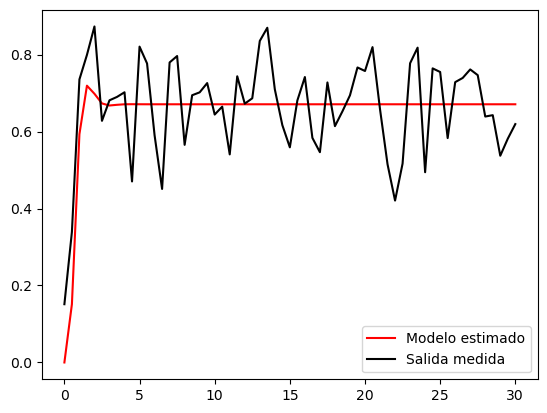

In [98]:
## Definir el modelo ARX    y(t) = G(z)u(t) + H(z)e(t)
## G = B/A,    H = 1/A
z = sym.symbols('z', complex=True)

## EVALUAR LA SELECCIÓN DEL TIEMPO DE MUESTREO

## Construir los polinomios A(z) y B(z)
A = 1 + theta[0]*z**-1 + theta[1]*z**-2  
B = theta[2]*z**-1+ theta[3]*z**-2

G = B/A
G = G.simplify()
G_e = control.tf([theta[2],theta[3]],[1,theta[0],theta[1]],dt)

H = 1/A
H = H.simplify()
H_e = control.tf([1,0,0],[1,theta[0],theta[1]],dt)

## Intento 1 - respuesta discreta.
## Averiguar cómo obtener los mismos datos que yn

_,ye = control.step_response(G_e,t)
plt.plot(t,ye,color = 'red')
plt.plot(t,yn,color = 'black')
plt.legend(['Modelo estimado','Salida medida'])
#plt.xlim([0, t[len(t)-1]])   

ECM = np.sqrt(np.dot((yn-ye).transpose(),(yn-ye)))/len(yn)


In [99]:
## Función de transferencia G(z)
print(G)
print(G_e)
gd = control.c2d(g,dt)
print(gd)

print(ECM)

(0.15136538518508*z + 0.391151223732855)/(z**2 - 0.334257752886419*z + 0.143056889539055)

   0.1514 z + 0.3912
-----------------------
z^2 - 0.3343 z + 0.1431

dt = 0.5


   0.2711 z + 0.2093
-----------------------
z^2 - 0.7517 z + 0.4724

dt = 0.5

0.01393523547457128


(array([0.16712888+0.3393005j, 0.16712888-0.3393005j]),
 array([-2.5841524+0.j]))

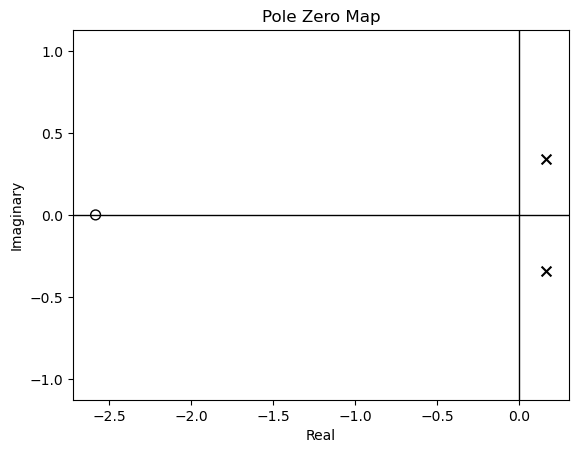

In [100]:
control.pzmap(G_e)

(array([0.37586854+0.57540368j, 0.37586854-0.57540368j]),
 array([-0.77211532+0.j]))

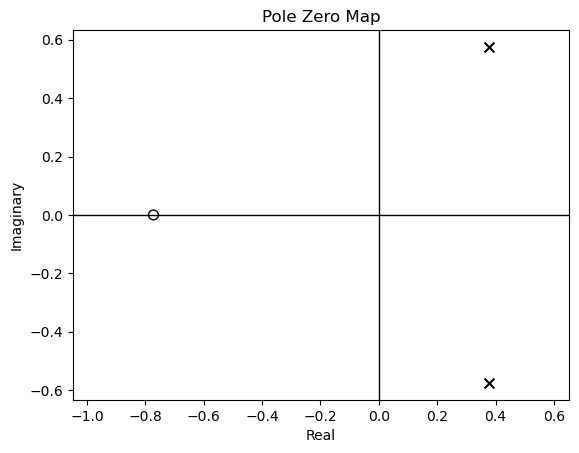

In [101]:
control.pzmap(gd)